### Trained the GAN for 1300 epochs

4 features : PRECT, QBP, PS, TBP


In [0]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as s
import pickle
import random
import torch
import seaborn as sns
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/Capstone Project/GAN-Capstone/")

In [0]:
# TODO: Enter the path to the stored pickle file
d_vars = pickle.load(open('data.pkl','rb'))

In [0]:
# We will only use non-zero values of PRECT to train our network
d_non_zero = d_vars[d_vars.PRECT>0]

In [6]:
d_non_zero.shape

(90951, 10)

In [0]:
d_non_zero.describe()

var_names,lat,lon,time,LHFLX,PRECT,PS,QBP,SHFLX,SOLIN,TBP
count,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06
mean,-3.662573e+00,2.963465e+00,9.942802e+01,6.046632e+01,4.140050e-08,9.507529e+04,3.139981e-03,1.430173e+01,2.836740e+02,2.523210e+02
std,5.653907e+01,1.001441e+02,5.750407e+01,7.841086e+01,1.161844e-07,1.038930e+04,2.630404e-03,3.997471e+01,3.764981e+02,1.502943e+01
min,-9.000000e+01,-1.800000e+02,0.000000e+00,-9.325116e+01,1.593949e-19,5.499596e+04,1.858080e-05,-1.656994e+02,0.000000e+00,2.127158e+02
25%,-5.589474e+01,-8.000000e+01,4.900000e+01,2.071997e+00,8.443093e-10,9.725915e+04,1.137669e-03,-3.471706e+00,0.000000e+00,2.469244e+02
50%,-6.631579e+00,2.500000e+00,1.000000e+02,1.945230e+01,5.240977e-09,1.003783e+05,2.270601e-03,6.828023e+00,0.000000e+00,2.545362e+02
75%,5.021053e+01,8.750000e+01,1.490000e+02,1.064865e+02,2.369674e-08,1.013462e+05,4.948887e-03,1.918639e+01,5.199216e+02,2.659229e+02
max,9.000000e+01,1.775000e+02,1.990000e+02,5.412509e+02,4.066384e-06,1.042599e+05,1.152809e-02,4.863447e+02,1.328776e+03,2.782828e+02


#### Feature Transformation

In [8]:
d_non_zero['PRECT_NEW'] = s.boxcox(d_non_zero.PRECT, 0.1)
d_non_zero['QBP_NEW'] = d_non_zero.QBP**(1/4) #s.boxcox(d_non_zero.QBP, 0.4)
d_non_zero['SHFLX_NEW'] = d_non_zero.SHFLX*(10**(-2))
d_non_zero['LHFLX_NEW'] = d_non_zero.LHFLX*(10**(-2))
d_non_zero['PS_NEW'] = d_non_zero.PS*(10**(-4))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [0]:
d_non_zero = (d_non_zero).astype({'QBP_NEW': 'float32','LHFLX_NEW': 'float32','SHFLX_NEW': 'float32','PS_NEW': 'float32'})

In [10]:
d_non_zero.dtypes

var_names
lat          float64
lon          float64
time           int64
LHFLX        float32
PRECT        float32
PS           float32
QBP          float32
SHFLX        float32
SOLIN        float32
TBP          float32
PRECT_NEW    float32
QBP_NEW      float32
SHFLX_NEW    float32
LHFLX_NEW    float32
PS_NEW       float32
dtype: object

###### Plot the transformed features

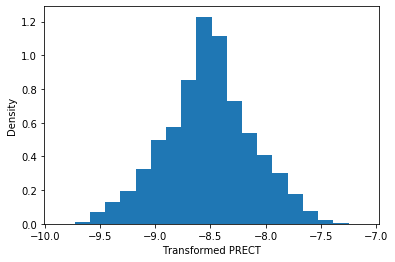

In [0]:
plt.hist(d_non_zero.PRECT_NEW.values, density=True, bins=20)
plt.xlabel('Transformed PRECT')
plt.ylabel('Density')
plt.show()

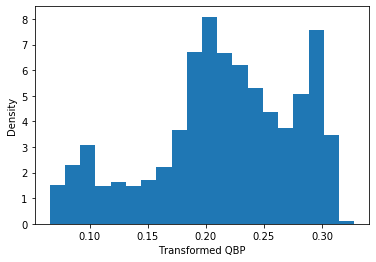

In [0]:
plt.hist(d_non_zero.QBP_NEW, density=True, bins=20)
plt.xlabel('Transformed QBP')
plt.ylabel('Density')
plt.show()

In [12]:
# TODO: Select which features to train the GAN on
# (keep in mind what features you select should effect the architecture of the model - ideally for more features you will need a deeper model)
data=np.array(d_non_zero[['PRECT_NEW','QBP_NEW','PS_NEW','TBP']])
data

array([[-8.7882309e+00,  9.3186721e-02,  6.7436752e+00,  2.1877846e+02],
       [-8.7889423e+00,  9.3218088e-02,  6.7439671e+00,  2.1878680e+02],
       [-8.7895212e+00,  9.3248993e-02,  6.7441936e+00,  2.1879404e+02],
       ...,
       [-8.4455757e+00,  1.9851312e-01,  1.0008727e+01,  2.5176146e+02],
       [-8.4590101e+00,  1.9848663e-01,  1.0008052e+01,  2.5177026e+02],
       [-8.4485226e+00,  1.9846590e-01,  1.0007248e+01,  2.5177927e+02]],
      dtype=float32)

In [13]:
data.shape

(90951, 4)

### GAN Model

With noisy 0 to 0.2 range of labels for real data, 0.8 to 1 range of labels for fake data

In [14]:
# TODO: Set the batch size
data_loader = torch.utils.data.DataLoader(data, batch_size=1024, shuffle=False)

# Num batches
num_batches = len(data_loader)
num_batches

89

###### Define Discriminator Network

In [0]:
# TODO: Modify the architecture if needed
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        # TODO: modify n_features if more variables selected
        n_features = 4
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
  
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(128, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x.cuda())
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

###### Define Generator Network

In [0]:
# TODO: Modify the architecture if needed
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        # TODO: modify n_out if more variables selected
        n_out = 4
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.ReLU(),
  
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            # nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
        )


    def forward(self, x):
        x = self.hidden0(x.cuda())
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        
        x = self.out(x)
        return x
generator = GeneratorNet()

In [0]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    n.cuda()
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0004)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

In [0]:
loss = nn.BCELoss()

In [0]:
torch.cuda.is_available()

True

In [0]:
def train_discriminator(optimizer, data, labels):

    N = real_data.size(0)

    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction = discriminator(data)
    prediction.cuda()
    labels = labels.cuda()
    
    error_total = loss(prediction, labels)
    error_total.backward()

    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_total, prediction

In [0]:
def train_generator(optimizer, fake_data, labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    prediction.cuda()

    labels = labels.cuda()
    
    # Calculate error and backpropagate
    error = loss(prediction, labels)

    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Checkpoints

Add a path to a checkpoint folder to store training checkpoints

In [0]:
# TODO: Add correct path
drive_root = "/content/drive/My Drive/Capstone Project/GAN-Capstone/"
checkpoint_dir = os.path.join(drive_root, "checkpoints")
# your name here
checkpoint_dir = os.path.join(checkpoint_dir, "akshata")

In [0]:
## TODO: if you are starting training from scratch, make sure you rm -r the contents of the checkpoint directory

In [0]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /content/drive/My Drive/Capstone Project/GAN-Capstone/checkpoints/akshata
Checkpoints folder already exists


In [0]:
# Restore the latest checkpoints
chkpts = os.listdir(checkpoint_dir)
if chkpts:
  latest = chkpts[0]
  print(latest)
  saved = torch.load(checkpoint_dir+'/'+latest)
  generator.load_state_dict(saved['gen_state_dict'])
  discriminator.load_state_dict(saved['disc_state_dict'])
  g_optimizer.load_state_dict(saved['gen_optimizer_state_dict'])
  d_optimizer.load_state_dict(saved['disc_optimizer_state_dict'])
  current_epoch = saved['epoch']+1
  g_error = saved['gen_loss']
  d_error = saved['disc_loss']
else:
  current_epoch = 0

current_epoch

checkpoint.pt


1000

In [0]:
dtype = torch.cuda.FloatTensor

In [0]:
# TODO: Set the number of epochs
num_epochs = 1300

for epoch in range(current_epoch, num_epochs):
  
  # TODO: modify the columns of the result dataframe if more variables selected
  results = pd.DataFrame(columns=['Prect','QBP','PS','TBP'])

  for n_batch,real_batch in enumerate(data_loader):
    N = real_batch.size(0)
   
    # 1. Train Discriminator
    real_data = real_batch
    real_data.cuda()
    
    # Generate fake data and detach 
    # (so gradients are not calculated for generator)
    noi = noise(N)
    noi.cuda()

    fake_data = generator(noi).detach()
    fake_data.cuda()

    ## add one percent noise to the labels
    one_prec_N = int((int(0.1*N)+1)/2)

    ## for real data - randomly shuffled labels in range from 0 to 0.2
    y_dis0 = np.zeros(N)
    y_dis0[:N-one_prec_N] = np.random.uniform(0.0,0.2000000001,N-one_prec_N)
    y_dis0[N-one_prec_N:] = np.random.uniform(0.8,1.0000000001,one_prec_N)
    random.shuffle(y_dis0)

    ## for fake data - randomly shuffled labels in range from 0.8 to 1.0
    y_dis1 = np.ones(N)
    y_dis1[:N-one_prec_N]= np.random.uniform(0.8,1.0000000001,N-one_prec_N)
    y_dis1[N-one_prec_N:]= np.random.uniform(0.0,0.2000000001,one_prec_N)
    random.shuffle(y_dis1)

    y_dis = np.concatenate((y_dis0,y_dis1),axis=0)
    y_torch = Variable(torch.from_numpy(y_dis).float())
    y_torch.cuda()
    
    #Train D
    error_real, pred_real = train_discriminator(d_optimizer, real_data ,Variable(torch.from_numpy(y_dis0).float()))
    error_fake, pred_fake = train_discriminator(d_optimizer, fake_data ,Variable(torch.from_numpy(y_dis1).float()))

    
    d_error = error_real + error_fake

    d_pred = []
    d_pred.append(pred_real)
    d_pred.append(pred_fake)    

    # 2. Train Generator
    fake_data = generator(noise(N))
    fake_data.cuda()
    
    # Train G
    y_gen = np.zeros(N)
    y_torch_gen = Variable(torch.from_numpy(y_gen).float())
    y_torch_gen.cuda()

    g_error = train_generator(g_optimizer, fake_data, y_torch_gen)

    # print d error and g error
    if (n_batch) % 100 == 0: 
      """logger.display_status(
                  epoch, num_epochs, n_batch, num_batches,
                  d_error, g_error
              )"""
      print(d_error,g_error,fake_data[0],epoch)
    
    results = results.append(pd.DataFrame(fake_data.tolist(), columns=results.columns))
  
  # save checkpoint
  checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pt')
  torch.save({'epoch': epoch,
              'gen_state_dict': generator.state_dict(),
              'disc_state_dict': discriminator.state_dict(),
              'gen_optimizer_state_dict': g_optimizer.state_dict(),
              'disc_optimizer_state_dict': d_optimizer.state_dict(),
              'gen_loss': g_error,
              'disc_loss': d_error,},
             checkpoint_path)
  
  ## TODO:  specify your results pickle file here
  pickle.dump(results, open('results_akshata_new.pkl', 'wb'))
  print('Saved model at ', checkpoint_path)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


tensor(1.9100, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([ -9.6669,   0.3936,  11.1936, 283.5468], device='cuda:0',
       grad_fn=<SelectBackward>) 1000
tensor(0.9868, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([ -9.8333,   0.3233,  10.1154, 266.7521], device='cuda:0',
       grad_fn=<SelectBackward>) 1000
tensor(0.8930, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([-8.7408e+00,  2.4793e-01,  1.0071e+01,  2.4994e+02], device='cuda:0',
       grad_fn=<SelectBackward>) 1000
tensor(0.9694, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([ -7.9228,  -0.3473,   5.8266, 162.7689], device='cuda:0',
       grad_fn=<SelectBackward>) 1000
tensor(0.9167, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.713

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([281])) that is different to the input size (torch.Size([281, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saved model at  /content/drive/My Drive/Capstone Project/GAN-Capstone/checkpoints/akshata/checkpoint.pt
tensor(1.4171, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([ -8.5545,   0.3926,  10.9588, 282.9627], device='cuda:0',
       grad_fn=<SelectBackward>) 1001
tensor(0.8534, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([ -9.9483,   0.4256,  10.8451, 295.1220], device='cuda:0',
       grad_fn=<SelectBackward>) 1001
tensor(0.8743, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([-9.3633e+00,  1.3246e-01,  9.7275e+00,  2.3470e+02], device='cuda:0',
       grad_fn=<SelectBackward>) 1001
tensor(0.9660, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor([-8.6391e+00,  6.2736e-02,  9.2050e+00,  2.3155e+02], device=

Explore the results

In [0]:
results = pickle.load(open('results_akshata_new.pkl', 'rb'))

In [0]:
results.describe()

,Prect,QBP,PS,TBP
count,1.867033e+06,1.867033e+06,1.867033e+06,1.867033e+06
mean,-8.324647e+00,1.296128e-01,9.021493e+00,2.390362e+02
std,7.469320e-01,2.275952e-01,1.466096e+00,3.727851e+01
min,-1.230278e+01,-9.240393e-01,2.857937e+00,6.673009e+01
25%,-8.837471e+00,-2.309155e-02,7.983289e+00,2.151589e+02
50%,-8.333647e+00,1.360561e-01,9.217613e+00,2.390024e+02
75%,-7.821166e+00,2.872939e-01,1.012650e+01,2.660305e+02
max,-4.707584e+00,1.013816e+00,1.332684e+01,3.624583e+02


Inverse transform the data to get values in the correct range

In [0]:
q = results.QBP**4
p = s.inv_boxcox(results.Prect, 0.1)
t = results.TBP
ps = (results.PS) * (10**4)

In [0]:
ans = pd.concat([p.reset_index(drop=True),
                 q.reset_index(drop=True),
                 t.reset_index(drop=True),
                 ps.reset_index(drop=True),
                 ], axis=1)

In [0]:
ans.describe()

,Prect,QBP,TBP,PS
count,1.848278e+06,1.867033e+06,1.867033e+06,1.867033e+06
mean,1.257981e-06,1.250034e-02,2.390362e+02,9.021493e+04
std,8.932671e-06,3.334485e-02,3.727851e+01,1.466096e+04
min,3.674628e-66,0.000000e+00,6.673009e+01,2.857937e+04
25%,5.230466e-10,6.125996e-05,2.151589e+02,7.983289e+04
50%,1.746405e-08,1.197454e-03,2.390024e+02,9.217613e+04
75%,2.478310e-07,8.956576e-03,2.660305e+02,1.012650e+05
max,1.724009e-03,1.056418e+00,3.624583e+02,1.332684e+05


A scatter plot of PRECT vs QBP

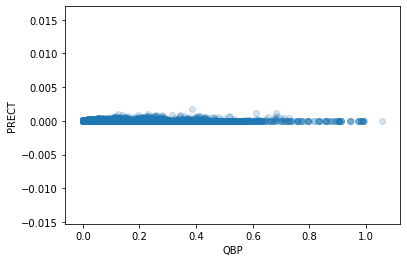

In [0]:
plt.scatter(ans.QBP, ans.Prect, alpha = 0.2)
plt.xlabel('QBP')
plt.ylabel('PRECT')
plt.show()

A scatter plot of PRECT vs TBP

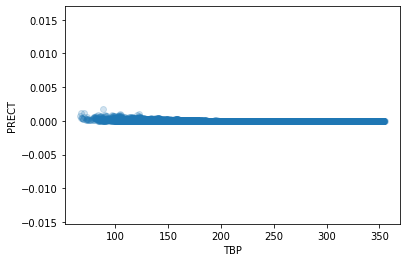

In [0]:
plt.scatter(ans.TBP, ans.Prect, alpha=0.2)
plt.xlabel('TBP')
plt.ylabel('PRECT')
plt.show()

Distribution of all generated variables

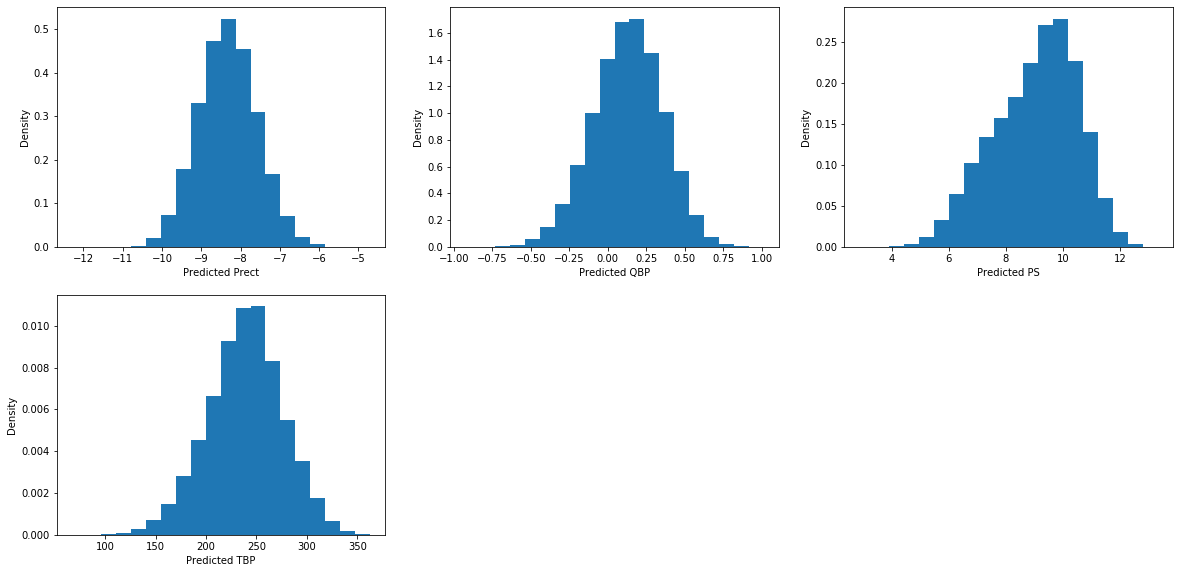

In [0]:
plt.figure(figsize=(20,15))
vars_to_plot = results.columns.to_list()
for i, var in enumerate(vars_to_plot):
  plt.subplot(3,3,i+1)
  plt.hist(results[var], density=True, bins=20)
  plt.xlabel('Predicted '+var)
  plt.ylabel('Density')

Plot variance of PRECT vs Bins of QBP

In [0]:
ans_sorted = ans.sort_values(by='QBP')

In [0]:
prect_vars_result = []
qbp_bins_result_str = []
for split in np.array_split(ans_sorted,10,axis = 0):
  prect_vars_result.append(np.std(split.Prect)**2)
  qbp_bins_result_str.append("{:.3f}".format(split.QBP.min()*(10**3))+" - "+"{:.3f}".format(split.QBP.max()*(10**3)))

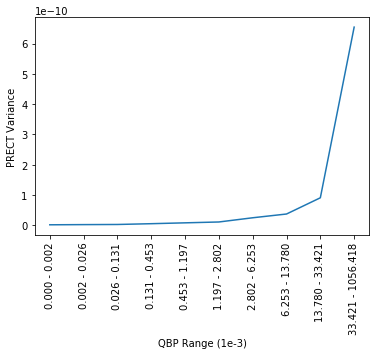

In [0]:
plt.plot(prect_vars_result)
plt.xticks(list(range(0,10)),labels=qbp_bins_result_str,rotation=90)
plt.xlabel('QBP Range (1e-3)')
plt.ylabel('PRECT Variance')
plt.show()